# CBOW

CBOW模型与Skip-Gram模型相反，其主要任务是根据给定的周围词来预测中心词。

In [1]:
sentences = [
    "Mazong is Boss",
    "Niuzong is Boss",
    "Xiaoniu is Worker",
    "Xiaoma is Worker"]
# 将所有句子连接在一起，然后用空格分隔成多个单词
words = ' '.join(sentences).split()
# 构建词汇表，去除重复的词
word_list = list(set(words))
# 创建一个字典，将每个词映射到一个唯一的索引
word_to_idx = {word: idx for idx, word in enumerate(word_list)}
# 创建一个字典，将每个索引映射到对应的词
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
voc_size = len(word_list) # 计算词汇表的大小
print(" 词汇表：", word_list) # 输出词汇表
print(" 词汇到索引的字典：", word_to_idx) # 输出词汇到索引的字典
print(" 索引到词汇的字典：", idx_to_word) # 输出索引到词汇的字典
print(" 词汇表大小：", voc_size) # 输出词汇表大小

 词汇表： ['Xiaoniu', 'is', 'Niuzong', 'Worker', 'Xiaoma', 'Boss', 'Mazong']
 词汇到索引的字典： {'Xiaoniu': 0, 'is': 1, 'Niuzong': 2, 'Worker': 3, 'Xiaoma': 4, 'Boss': 5, 'Mazong': 6}
 索引到词汇的字典： {0: 'Xiaoniu', 1: 'is', 2: 'Niuzong', 3: 'Worker', 4: 'Xiaoma', 5: 'Boss', 6: 'Mazong'}
 词汇表大小： 7


In [3]:
# 生成 CBOW 训练数据
def create_cbow_dataset(sentences, window_size=2):
    data = []# 初始化数据
    for sentence in sentences:
        sentence = sentence.split()  # 将句子分割成单词列表
        for idx, word in enumerate(sentence):  # 遍历单词及其索引
            # 获取上下文词汇，将当前单词前后各 window_size 个单词作为周围词
            context_words = sentence[max(idx - window_size, 0):idx] \
                + sentence[idx + 1:min(idx + window_size + 1, len(sentence))]
            # 将当前单词与上下文词汇作为一组训练数据
            data.append((word, context_words))
    return data
# 使用函数创建 CBOW 训练数据
cbow_data = create_cbow_dataset(sentences)
# 打印未编码的 CBOW 数据样例
print("CBOW 数据样例（未编码）：", cbow_data)

CBOW 数据样例（未编码）： [('Mazong', ['is', 'Boss']), ('is', ['Mazong', 'Boss']), ('Boss', ['Mazong', 'is']), ('Niuzong', ['is', 'Boss']), ('is', ['Niuzong', 'Boss']), ('Boss', ['Niuzong', 'is']), ('Xiaoniu', ['is', 'Worker']), ('is', ['Xiaoniu', 'Worker']), ('Worker', ['Xiaoniu', 'is']), ('Xiaoma', ['is', 'Worker']), ('is', ['Xiaoma', 'Worker']), ('Worker', ['Xiaoma', 'is'])]


In [4]:
# 定义 One-Hot 编码函数
import torch # 导入 torch 库
def one_hot_encoding(word, word_to_idx):
    tensor = torch.zeros(len(word_to_idx)) # 创建一个长度与词汇表相同的全 0 张量
    tensor[word_to_idx[word]] = 1  # 将对应词的索引设为 1
    return tensor  # 返回生成的 One-Hot 向量
# 展示 One-Hot 编码前后的数据
word_example = "Boss"
print("One-Hot 编码前的单词：", word_example)
print("One-Hot 编码后的向量：", one_hot_encoding(word_example, word_to_idx))

One-Hot 编码前的单词： Boss
One-Hot 编码后的向量： tensor([0., 0., 0., 0., 0., 1., 0.])


In [5]:
# 定义 CBOW 模型
import torch.nn as nn # 导入 neural network
class CBOW(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(CBOW, self).__init__()
        # 从词汇表大小到嵌入大小的线性层（权重矩阵）
        self.input_to_hidden = nn.Linear(voc_size,
                                         embedding_size, bias=False)
        # 从嵌入大小到词汇表大小的线性层（权重矩阵）
        self.hidden_to_output = nn.Linear(embedding_size,
                                          voc_size, bias=False)
    def forward(self, X): # X: [num_context_words, voc_size]
        # 生成嵌入：[num_context_words, embedding_size]
        embeddings = self.input_to_hidden(X)
        # 计算隐藏层，求嵌入的均值：[embedding_size]
        hidden_layer = torch.mean(embeddings, dim=0)
        # 生成输出层：[1, voc_size]
        output_layer = self.hidden_to_output(hidden_layer.unsqueeze(0))
        return output_layer
embedding_size = 2 # 设定嵌入层的大小，这里选择 2 是为了方便展示
cbow_model = CBOW(voc_size,embedding_size)  # 实例化 CBOW 模型
print("CBOW 模型：", cbow_model)

CBOW 模型： CBOW(
  (input_to_hidden): Linear(in_features=7, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=7, bias=False)
)


Epoch: 100, Loss: 1.9373655021190643
Epoch: 200, Loss: 1.9209599991639454
Epoch: 300, Loss: 1.9037179152170818
Epoch: 400, Loss: 1.8845533231894176
Epoch: 500, Loss: 1.8623665670553844
Epoch: 600, Loss: 1.8360206385453541
Epoch: 700, Loss: 1.80436576406161
Epoch: 800, Loss: 1.7663360834121704
Epoch: 900, Loss: 1.7211458186308544
Epoch: 1000, Loss: 1.6685955325762432


Text(0, 0.5, ' 损失 ')

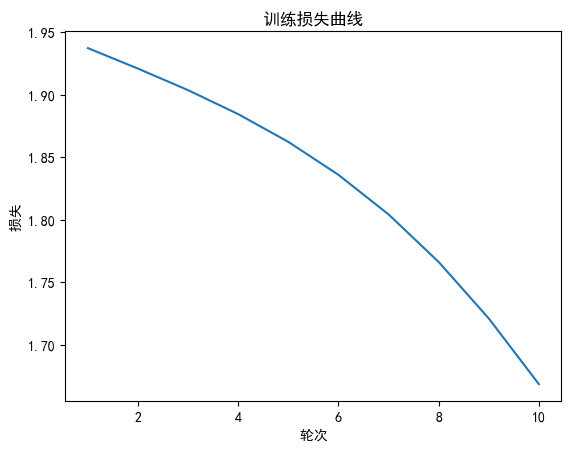

In [6]:
learning_rate = 0.001 # 设置学习速率
epochs = 1000 # 设置训练轮次
criterion = nn.CrossEntropyLoss()  # 定义交叉熵损失函数
import torch.optim as optim # 导入随机梯度下降优化器
optimizer = optim.SGD(cbow_model.parameters(), lr=learning_rate)
# 开始训练循环
loss_values = []  # 用于存储每轮的平均损失值
for epoch in range(epochs):
    loss_sum = 0 # 初始化损失值
    for target, context_words in cbow_data:
        # 将上下文词转换为 One-Hot 向量并堆叠
        X = torch.stack([one_hot_encoding(word, word_to_idx) for word in context_words]).float()
        # 将目标词转换为索引值
        y_true = torch.tensor([word_to_idx[target]], dtype=torch.long)
        y_pred = cbow_model(X)  # 计算预测值
        loss = criterion(y_pred, y_true)  # 计算损失
        loss_sum += loss.item() # 累积损失
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    if (epoch+1) % 100 == 0: # 输出每 100 轮的损失，并记录损失
      print(f"Epoch: {epoch+1}, Loss: {loss_sum/len(cbow_data)}")
      loss_values.append(loss_sum / len(cbow_data))
# 绘制训练损失曲线
import matplotlib.pyplot as plt # 导入 matplotlib
# 绘制二维词向量图
plt.rcParams["font.family"]=['SimHei'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.plot(range(1, epochs//100 + 1), loss_values) # 绘图
plt.title(' 训练损失曲线 ') # 图题
plt.xlabel(' 轮次 ') # X 轴 Label
plt.ylabel(' 损失 ') # Y

In [7]:
# 输出 CBOW 习得的词嵌入
print("CBOW 词嵌入：")
for word, idx in word_to_idx.items(): # 输出每个词的嵌入向量
 print(f"{word}: {cbow_model.input_to_hidden.weight[:,idx].detach().numpy()}")

CBOW 词嵌入：
Xiaoniu: [0.44538912 0.18468097]
is: [-0.8403361   0.16707343]
Niuzong: [0.2224674  0.43625876]
Worker: [1.0149107  0.17956404]
Xiaoma: [0.2299125  0.35326132]
Boss: [0.16271278 0.34884444]
Mazong: [-0.05343215  0.445842  ]
